# 합성곱 신경망(CNN)

위에 해당하는 그림은 기존의 Fully Connected Neural Network

아래에 해당하는 그림이 이번에 우리가 알아볼 Convolutional Neural Network

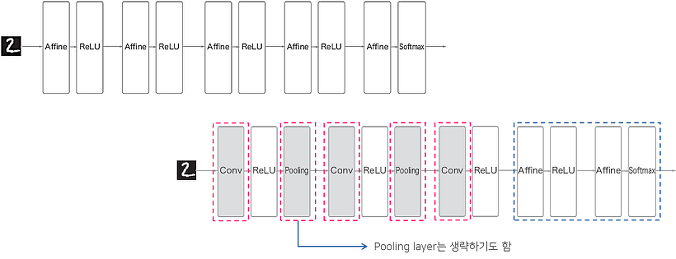

기존의 Fully Connected Neural Network를 vision에 사용하면 아래와 같은 문제들이 있다. 

- Training Time
- Network size
- Number of parameters (파라미터가 많아지면?)

CNN은 신호 처리, 이미지 or 영상 처리, 음성 인식 등 여러 분야에서 사용